# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import os
import random

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [75]:
# Define a function to load data and aggregate them


def combine_stock_data(file_names):
    combined_data = []

    for file in file_names:
        stock_name = os.path.basename(file).split('_')[0]
        df = pd.read_csv(file, usecols=lambda col: col != 'Name')
        df.columns = ['Date'] + [f'{stock_name}_{col}' for col in df.columns[1:]]
        df['Date'] = pd.to_datetime(df['Date'])
        combined_data.append(df)

    merged_df = combined_data[0]
    for df in combined_data[1:]:
        merged_df = pd.merge(merged_df, df, on='Date', how='outer')

    merged_df.set_index('Date', inplace=True)
    return merged_df



In [76]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

file_names = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
stock_data = combine_stock_data(file_names)

In [77]:
# View specifics of the data
stock_data.head()


,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
Date,,,,,,,,,,,,,,,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127.0,211.47,218.05,209.32,217.83,13137450.0,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418.0
2006-01-04,47.48,47.73,46.69,47.25,7440914.0,222.17,224.70,220.09,222.84,15292353.0,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661.0
2006-01-05,47.16,48.20,47.11,47.65,5417258.0,223.22,226.00,220.97,225.85,10815661.0,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610.0
2006-01-06,47.97,48.58,47.32,47.87,6154285.0,228.66,235.49,226.85,233.06,17759521.0,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092.0
2006-01-09,46.55,47.10,46.40,47.08,8945056.0,233.44,236.94,230.70,233.68,12795837.0,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836.0


In [78]:
stock_data.shape

(3020, 20)

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [79]:
# Handle Missing Values

missing_rows = stock_data[stock_data.isnull().any(axis=1)]
print(missing_rows)

def handle_missing_values(df):
    missing_before = df.isnull().sum()
    print("Missing values before handling:\n", missing_before)

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(method='ffill')
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    missing_after = df.isnull().sum()
    print("\nMissing values after handling:\n", missing_after)

    return df

combined_stock_data = handle_missing_values(stock_data)

            AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                  
2010-04-01        NaN        NaN       NaN         NaN          NaN   
2017-07-31    1019.05    1019.05    987.02      987.78    7352063.0   

            GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  GOOGL_Volume  \
Date                                                                       
2010-04-01         NaN         NaN        NaN          NaN           NaN   
2017-07-31       960.0      961.19     941.72        945.5     2293389.0   

            IBM_Open  IBM_High  IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  \
Date                                                                        
2010-04-01    128.95    129.31   127.55     128.25     4980625        NaN   
2017-07-31       NaN    144.93      NaN     144.67     4355718       73.3   

            MSFT_High  MSFT_Low  MSFT_Close  MSFT_Volume  
Date                                      

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

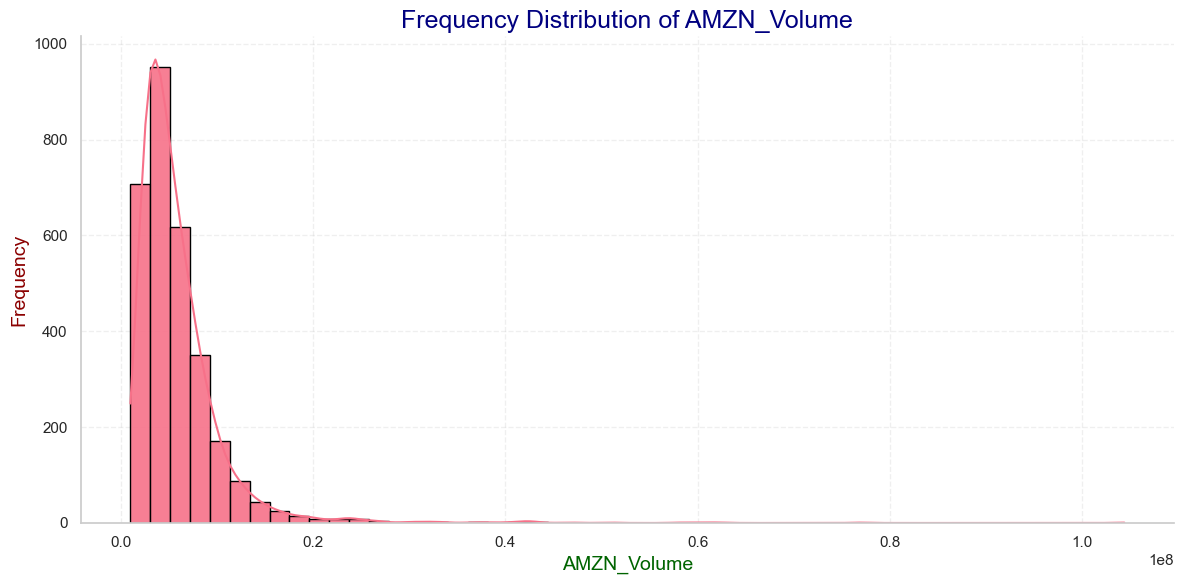

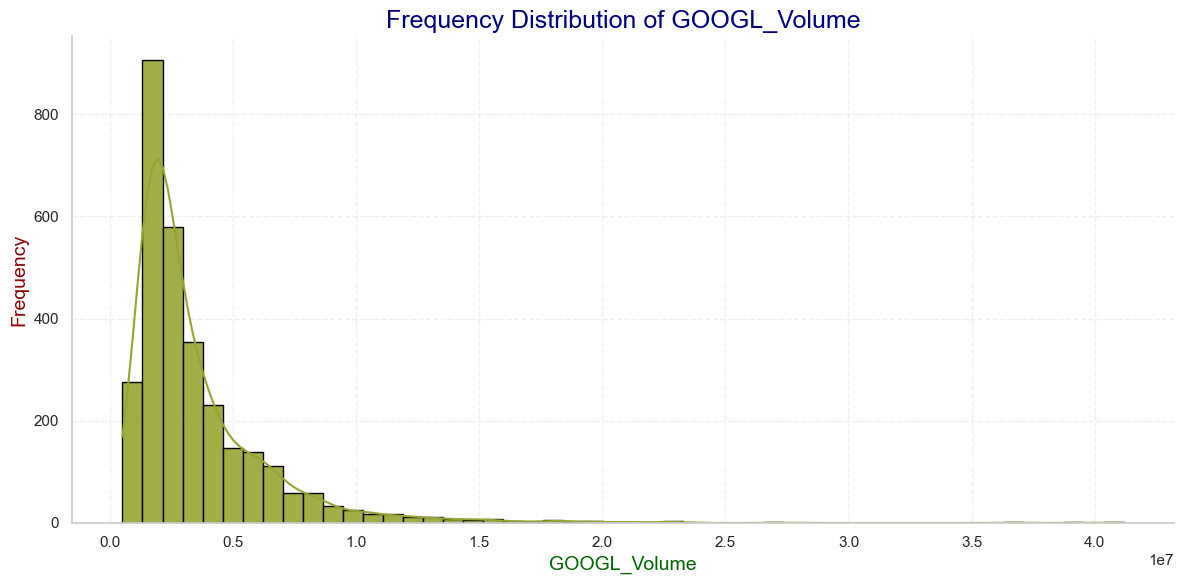

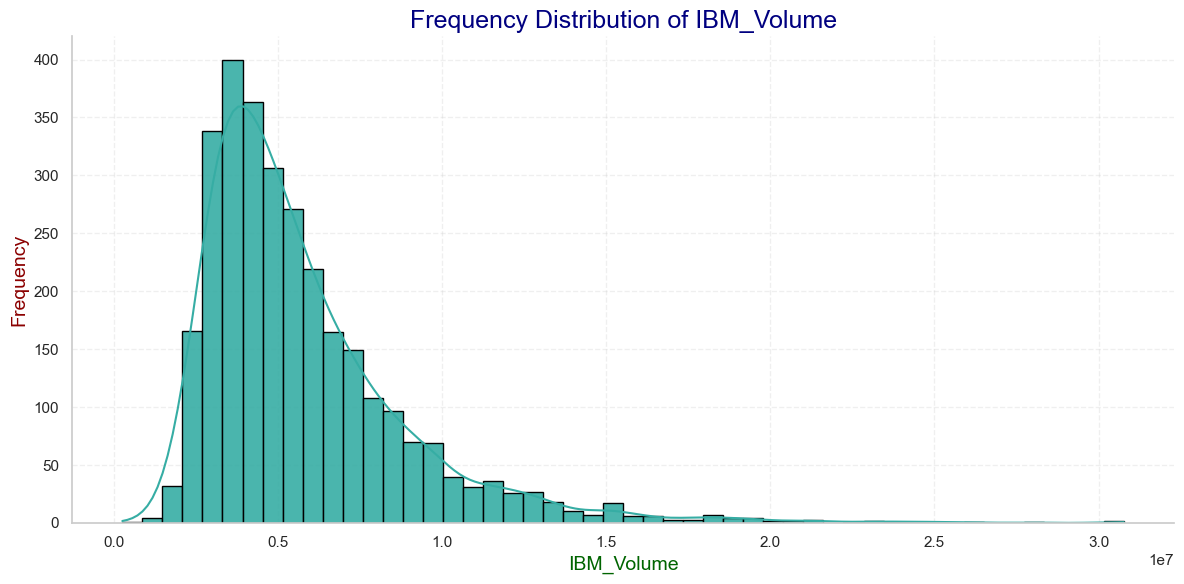

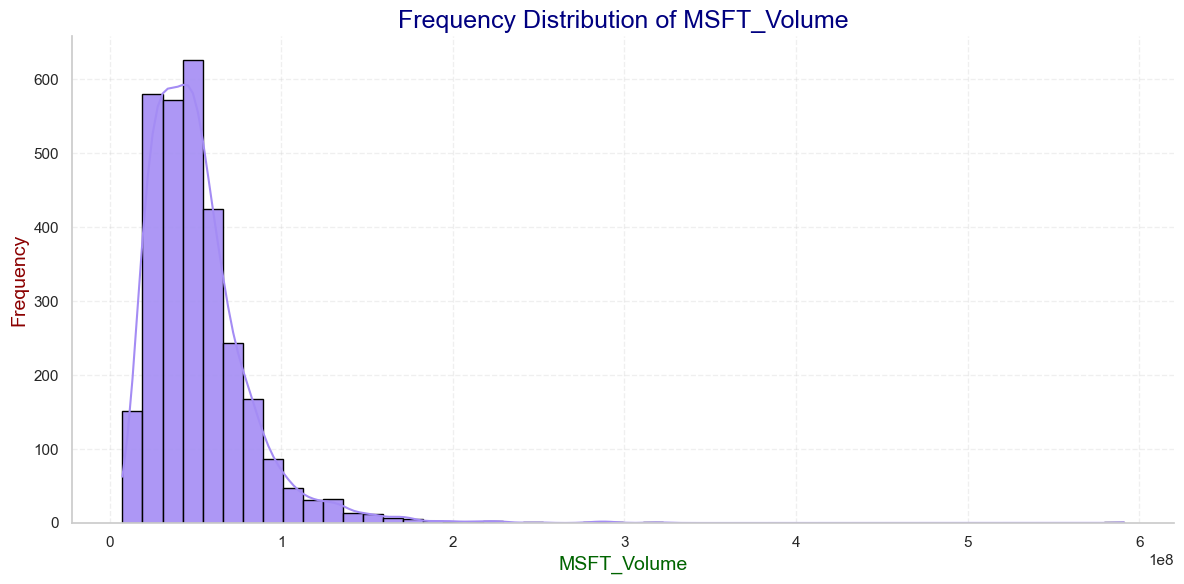

In [80]:
# Frequency distribution of volumes

def plot_volume_distribution_stockwise(df, keyword='Volume'):
    numeric_cols = df.select_dtypes(include='number').columns
    volume_like_cols = [col for col in numeric_cols if keyword.lower() in col.lower()]

    if not volume_like_cols:
        print(f"No numeric columns found with keyword '{keyword}'.")
        return

    color_palette = sns.color_palette("husl", len(volume_like_cols))

    for i, col in enumerate(volume_like_cols):
        plt.figure(figsize=(12, 6))
        sns.histplot(
            df[col].fillna(0),
            bins=50,
            kde=True,
            color=color_palette[i],
            edgecolor='black',
            alpha=0.9
        )
        plt.title(f'Frequency Distribution of {col}', fontsize=18, color='navy')
        plt.xlabel(col, fontsize=14, color='darkgreen')
        plt.ylabel('Frequency', fontsize=14, color='darkred')
        plt.grid(True, linestyle='--', alpha=0.3)
        sns.despine()
        plt.tight_layout()
        plt.show()

plot_volume_distribution_stockwise(combined_stock_data)


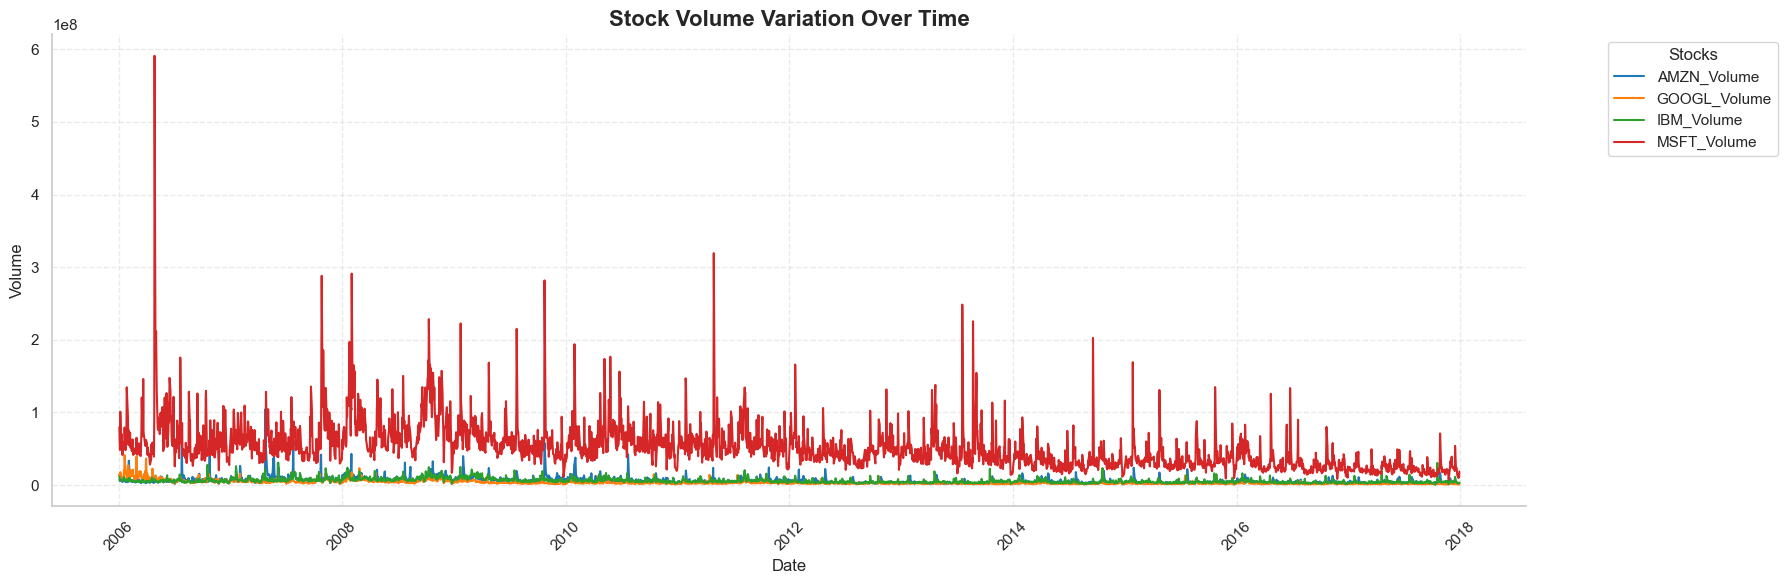

In [81]:
# Stock volume variation over time


def plot_volume_over_time_stockwise(df, keyword='Volume'):
    # Use Seaborn style for cleaner aesthetics
    sns.set(style="whitegrid")

    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index)
        except Exception as e:
            print("Index must be datetime or convertible to datetime. Error:", e)
            return

    # Identify volume-related columns
    volume_cols = [col for col in df.columns if keyword.lower() in col.lower()]
    if not volume_cols:
        print(f"No columns found containing the keyword '{keyword}'.")
        return

    # Plotting
    plt.figure(figsize=(18, 6))
    color_palette = sns.color_palette("tab10", len(volume_cols))  # or use "husl", "Set2", etc.
    
    for i, col in enumerate(volume_cols):
        plt.plot(df.index, df[col], label=col, color=color_palette[i], linewidth=1.5)

    plt.title('Stock Volume Variation Over Time', fontsize=16, weight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Volume', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.4)
    sns.despine()  # Remove top and right spines
    plt.tight_layout()
    plt.show()

plot_volume_over_time_stockwise(combined_stock_data)

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

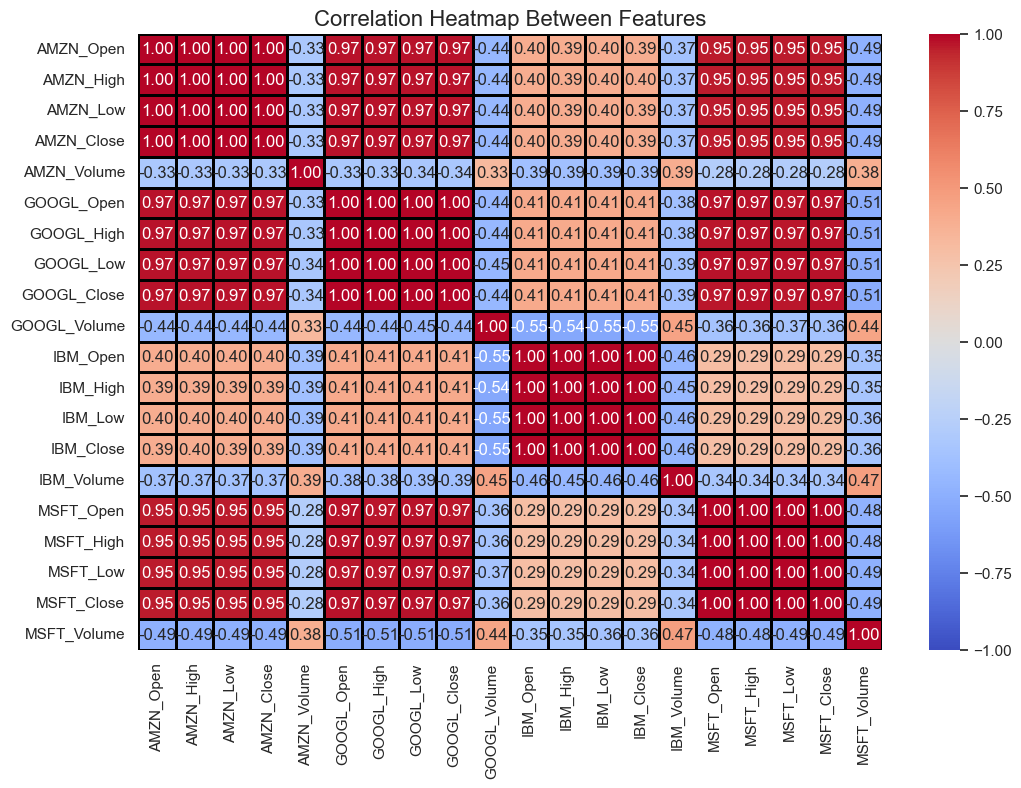

In [82]:
# Analyse correlations

correlation_matrix = combined_stock_data.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=1, linecolor='black')
plt.title('Correlation Heatmap Between Features', fontsize=16)
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [83]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, window_size=20, stride=1, target_stocks=None):
    if target_stocks is None:
        target_stocks = [col for col in df.columns if 'Close' in col]

    data = df.values
    target_indices = [df.columns.get_loc(col) for col in target_stocks]
    X, y = [], []

    for start in range(0, len(df) - window_size):
        if start + window_size >= len(df):
            break
        X.append(data[start : start + window_size])
        y.append(data[start + window_size, target_indices])

    return np.array(X), np.array(y)



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [84]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y, x_scaler=None, y_scaler=None):
    if x_scaler is None:
        x_scaler = StandardScaler()
    if y_scaler is None:
        y_scaler = StandardScaler()

    n, w, f = X.shape
    X_scaled = x_scaler.fit_transform(X.reshape(-1, f)).reshape(n, w, f)
    y_scaled = y_scaler.fit_transform(y)

    return X_scaled, y_scaled, x_scaler, y_scaler


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

In [85]:
def prepare_data_for_rnn(master_data, target_stocks, window_size, window_stride, train_test_split_ratio=0.8):
    X_windowed, y_windowed = create_windowed_data(master_data, window_size, window_stride, target_stocks)
    split_idx = int(len(X_windowed) * train_test_split_ratio)
    X_train, X_test = X_windowed[:split_idx], X_windowed[split_idx:]
    y_train, y_test = y_windowed[:split_idx], y_windowed[split_idx:]
    X_train, y_train, x_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    X_test, y_test, _, _ = scale_windowed_data(X_test, y_test, x_scaler, y_scaler)
    return X_train, y_train, X_test, y_test, y_scaler

master_data = combined_stock_data
target_cols = ['AMZN_Close']
window_size = 20
window_stride = 1
train_test_split_ratio = 0.8

X_train, y_train, X_test, y_test, y_scaler = prepare_data_for_rnn(
    master_data, target_cols, window_size, window_stride, train_test_split_ratio
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (2400, 20, 20), y_train shape: (2400, 1)
X_test shape: (600, 20, 20), y_test shape: (600, 1)


#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [86]:
# Define a function to create input and output data points from the master DataFrame

def create_train_val_split(df, target_stocks, window_size, window_stride, split_ratio=0.8):
    
    X_windowed, y_windowed = create_windowed_data(df, window_size, window_stride, target_stocks)
    split_idx = int(len(X_windowed) * split_ratio)
    X_train, X_val = X_windowed[:split_idx], X_windowed[split_idx:]
    y_train, y_val = y_windowed[:split_idx], y_windowed[split_idx:]
    X_train, y_train, x_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    X_val, y_val, _, _ = scale_windowed_data(X_val, y_val, x_scaler, y_scaler)

    return X_train, y_train, X_val, y_val, y_scaler



We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

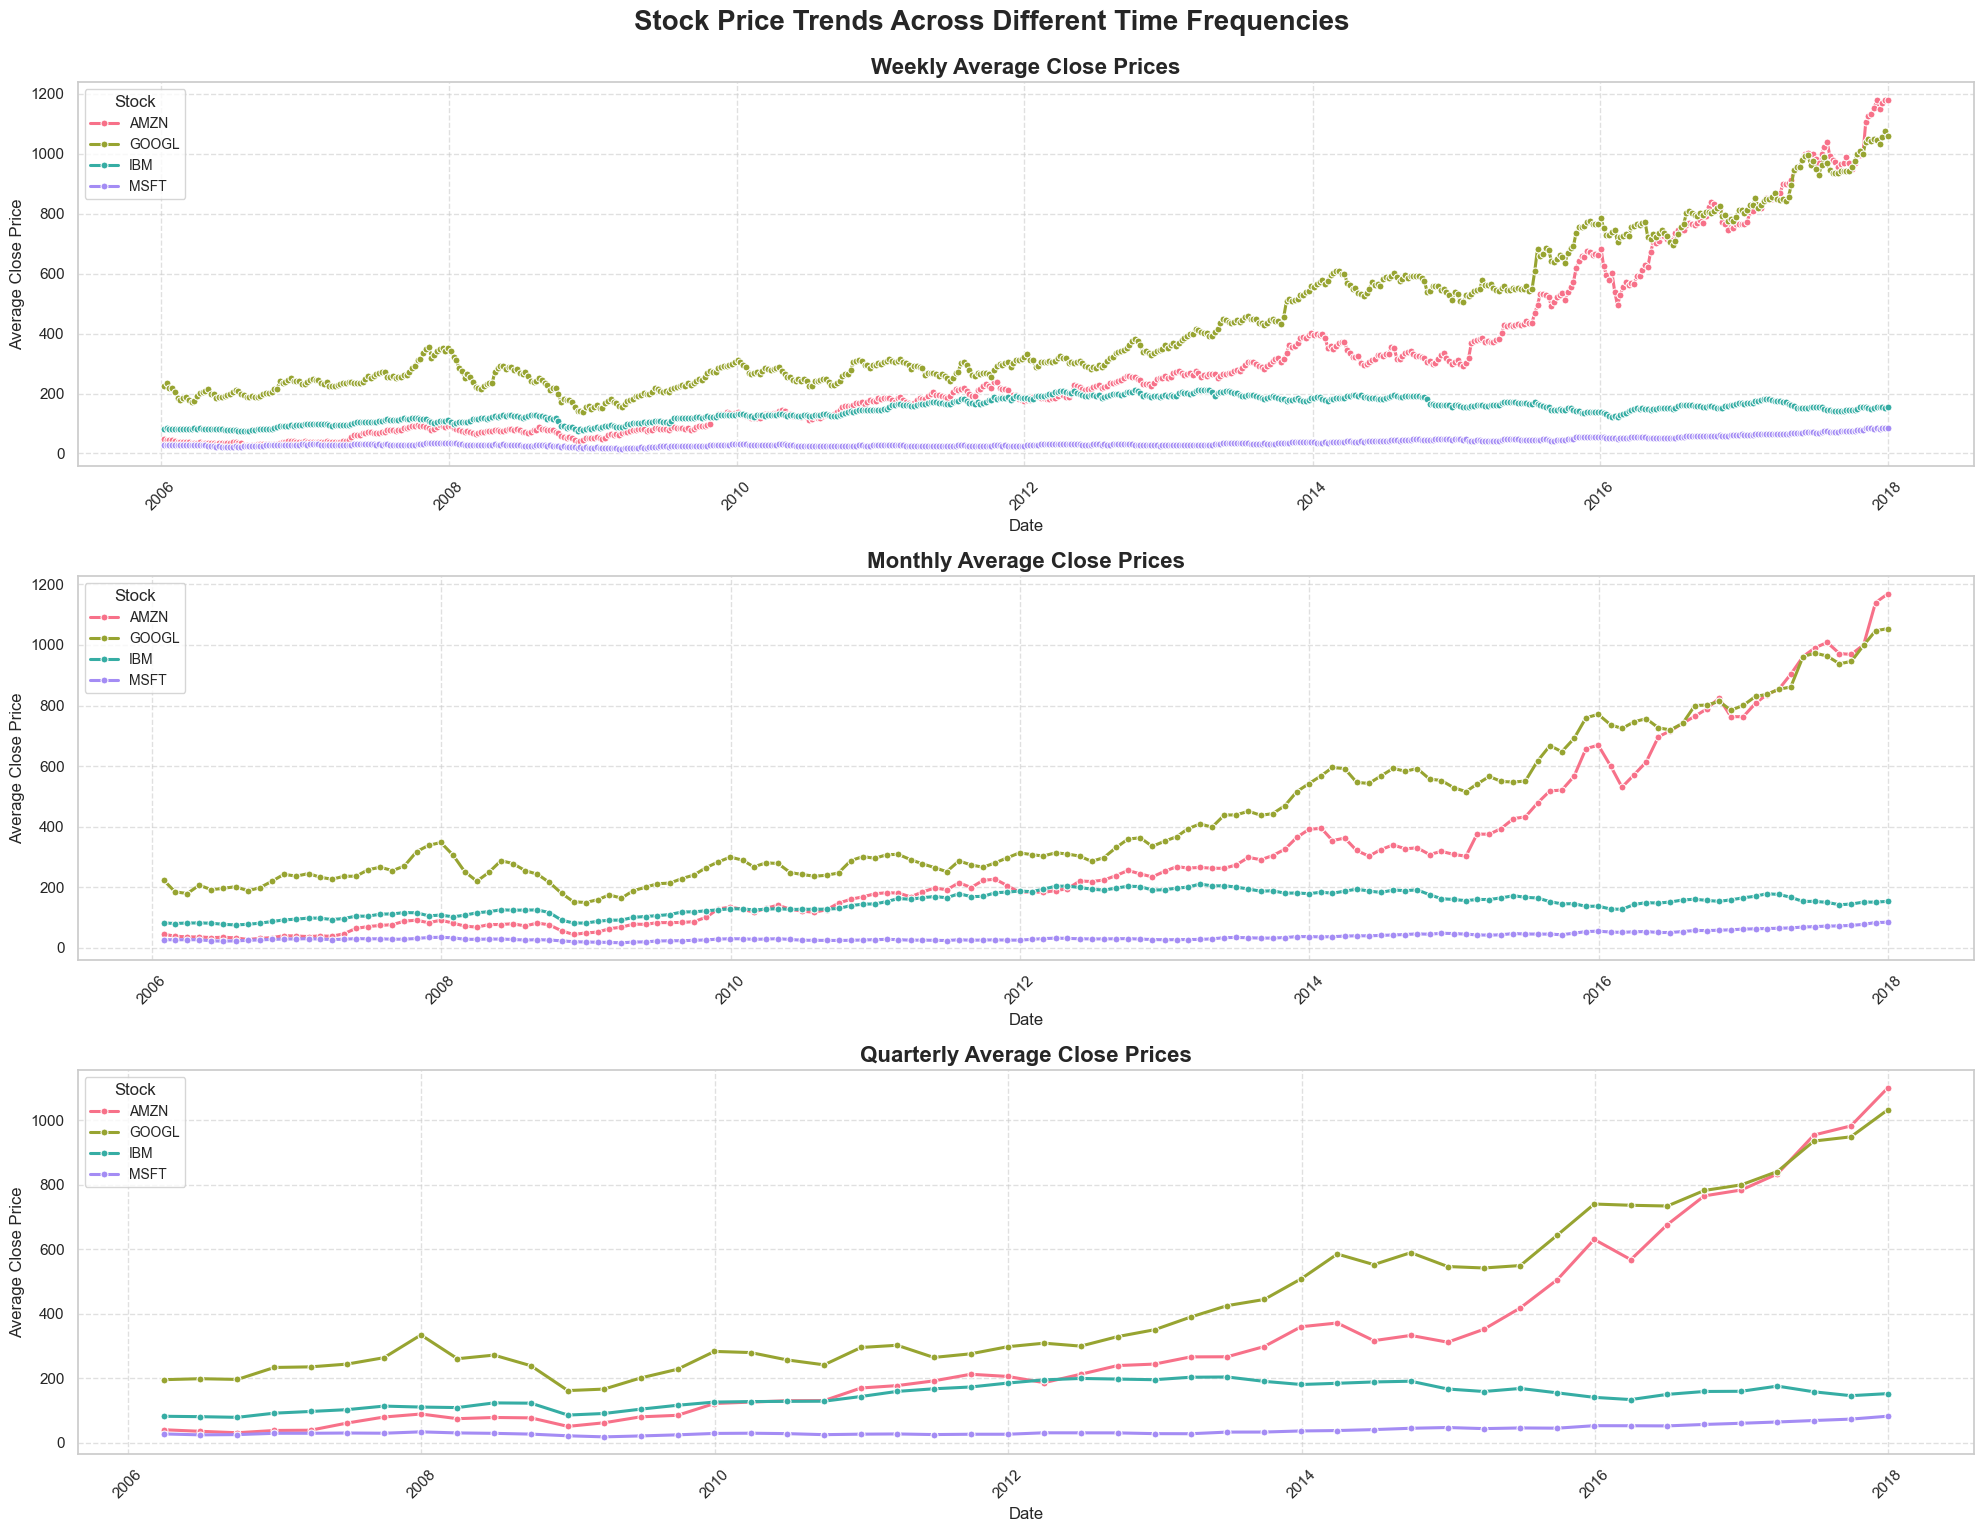

In [ ]:
# Checking for patterns in different sequence lengths


combined_stock_data.index = pd.to_datetime(combined_stock_data.index)
close_cols = [col for col in combined_stock_data.columns if col.endswith('_Close')]
freq_map = {'W': 'Weekly', 'M': 'Monthly', 'Q': 'Quarterly'}

sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", len(close_cols))

plt.figure(figsize=(20, 15))

for i, (freq, label) in enumerate(freq_map.items(), start=1):
    resampled = combined_stock_data[close_cols].resample(freq).mean()
    plt.subplot(3, 1, i)
    for j, col in enumerate(close_cols):
        sns.lineplot(
            x=resampled.index,
            y=resampled[col],
            label=col.replace('_Close', ''),
            color=palette[j],
            linewidth=2.2,
            marker="o",
            markersize=5
        )
    plt.title(f"{label} Average Close Prices", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Average Close Price", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Stock', loc='best', fontsize=10)

plt.tight_layout()
plt.suptitle("Stock Price Trends Across Different Time Frequencies", fontsize=20, fontweight='bold', y=1.02)
plt.show()




#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [88]:
# Create data instances from the master data frame using decided window size and window stride
window_size = 20       
window_stride = 1      
target_stocks = ['AMZN']
target_cols = [f"{stock}_Close" for stock in target_stocks]
split_ratio = 0.8      

X_train, y_train, X_val, y_val, y_scaler = create_train_val_split(
    combined_stock_data,
    target_cols,
    window_size,
    window_stride,
    split_ratio
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (2400, 20, 20)
y_train shape: (2400, 1)
X_val shape: (600, 20, 20)
y_val shape: (600, 1)


In [89]:
# Check the number of data points generated
print(f"Number of Training Data Points (X_train): {len(X_train)}")
print(f"Number of Training Data Points (y_train): {len(y_train)}")
print(f"Number of Validation Data Points (X_val): {len(X_val)}")
print(f"Number of Validation Data Points (y_val): {len(y_val)}")

Number of Training Data Points (X_train): 2400
Number of Training Data Points (y_train): 2400
Number of Validation Data Points (X_val): 600
Number of Validation Data Points (y_val): 600


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [90]:
# Check if the datasets are compatible inputs to neural networks
print("Training Set:")
print(f"X_train shape: {X_train.shape}")  # Expected: (num_samples, window_size, num_features)
print(f"y_train shape: {y_train.shape}")  # Expected: (num_samples, num_target_stocks)

print("\nValidation Set:")
print(f"X_val shape: {X_val.shape}")      # Expected: (num_samples, window_size, num_features)
print(f"y_val shape: {y_val.shape}") 


Training Set:
X_train shape: (2400, 20, 20)
y_train shape: (2400, 1)

Validation Set:
X_val shape: (600, 20, 20)
y_val shape: (600, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(units, activation, input_shape, dropout_rate, output_dim):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN

units_list = [16, 32, 64]
dropout_rates = [0.1, 0.2]
activation_list = ['tanh', 'relu']
input_shape = X_train.shape[1:]
output_dim = y_train.shape[1]

best_val_loss = float('inf')
best_model = None
best_config = None
results = []

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for units in units_list:
    for dropout in dropout_rates:
        for activation in activation_list:
            model = create_simple_rnn_model(units, activation, input_shape, dropout, output_dim)
            history = model.fit(
                X_train, y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            val_loss = history.history['val_loss'][-1]
            results.append((units, dropout, activation, val_loss))
            print(f"Config: units={units}, dropout={dropout}, activation={activation}, val_loss={val_loss:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = (units, dropout, activation)


Config: units=16, dropout=0.1, activation=tanh, val_loss=0.6671
Config: units=16, dropout=0.1, activation=relu, val_loss=0.2683
Config: units=16, dropout=0.2, activation=tanh, val_loss=1.3980
Config: units=16, dropout=0.2, activation=relu, val_loss=0.1782
Config: units=32, dropout=0.1, activation=tanh, val_loss=0.5558
Config: units=32, dropout=0.1, activation=relu, val_loss=0.0579
Config: units=32, dropout=0.2, activation=tanh, val_loss=0.1253
Config: units=32, dropout=0.2, activation=relu, val_loss=0.0850
Config: units=64, dropout=0.1, activation=tanh, val_loss=0.1152
Config: units=64, dropout=0.1, activation=relu, val_loss=0.0995
Config: units=64, dropout=0.2, activation=tanh, val_loss=0.2818
Config: units=64, dropout=0.2, activation=relu, val_loss=0.0413


In [93]:
# Find the best configuration based on evaluation metrics

print(f"Best Config Found: Units={best_config[0]}, Dropout={best_config[1]}, Activation={best_config[2]}")

Best Config Found: Units=64, Dropout=0.2, Activation=relu


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [94]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

final_model = create_simple_rnn_model(
    best_config[0], best_config[2], input_shape, best_config[1], output_dim
)

final_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4997 - mae: 0.8045 - val_loss: 0.1795 - val_mae: 0.3426
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1368 - mae: 0.2782 - val_loss: 0.1088 - val_mae: 0.2636
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0951 - mae: 0.2305 - val_loss: 0.0680 - val_mae: 0.1999
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0689 - mae: 0.1938 - val_loss: 0.0489 - val_mae: 0.1667
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533 - mae: 0.1721 - val_loss: 0.0393 - val_mae: 0.1496
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - mae: 0.1637 - val_loss: 0.0346 - val_mae: 0.1381
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0369 - mae: 0.1424 - val_loss: 0.0291 - val_mae: 0.1263
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397 - mae: 0.1421 - val_loss: 0.0261 - val_mae: 0.1199
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - mae: 

Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


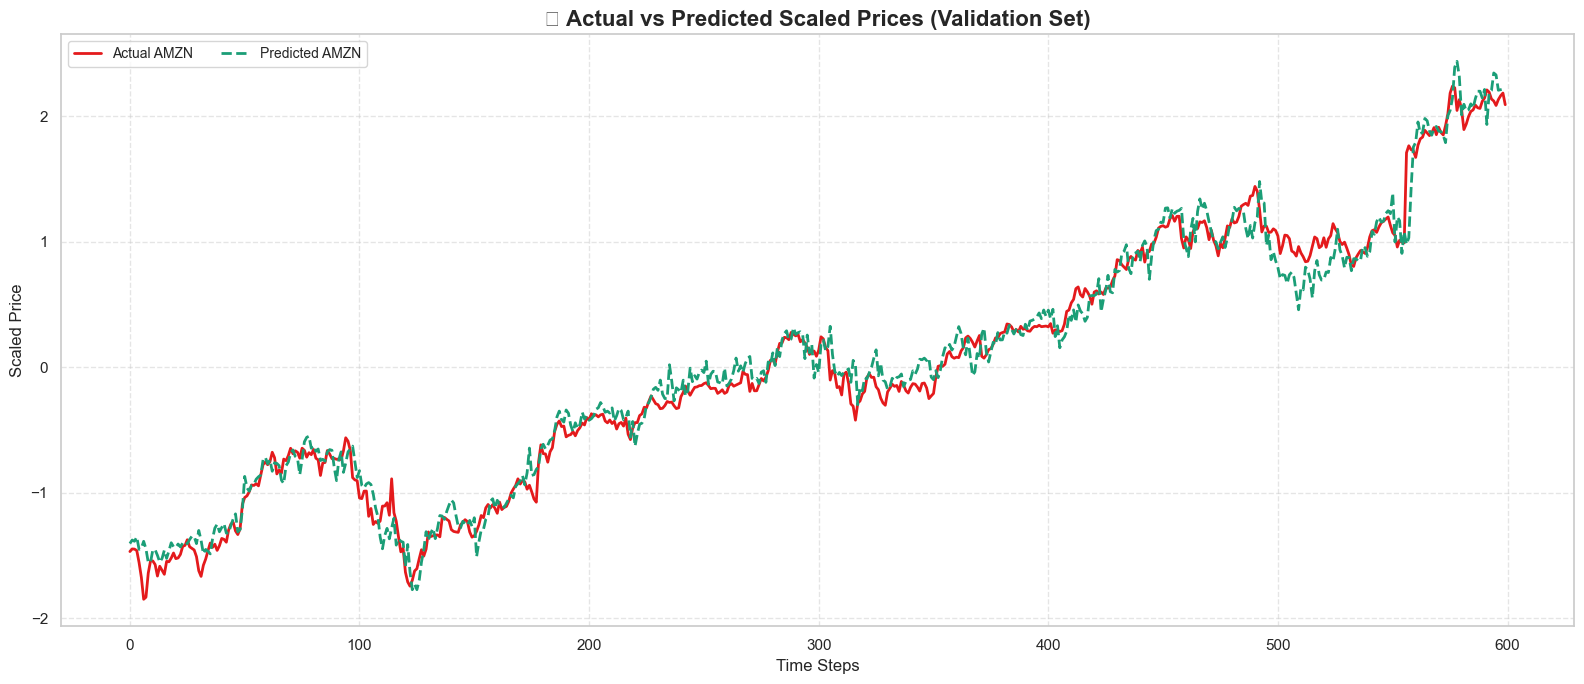

In [95]:
# Predict on the test data and plot

y_pred = final_model.predict(X_val)
sns.set(style='whitegrid')

# Generate distinct color palettes
actual_colors = sns.color_palette('Set1', n_colors=y_pred.shape[1])
predicted_colors = sns.color_palette('Dark2', n_colors=y_pred.shape[1])

plt.figure(figsize=(16, 7))

for i in range(y_pred.shape[1]):
    plt.plot(y_val[:, i], color=actual_colors[i], linewidth=2, label=f'Actual {target_stocks[i]}')
    plt.plot(y_pred[:, i], color=predicted_colors[i], linestyle='--', linewidth=2, label=f'Predicted {target_stocks[i]}')

plt.title('📈 Actual vs Predicted Scaled Prices (Validation Set)', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Scaled Price', fontsize=12)
plt.legend(loc='best', fontsize=10, ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [96]:
# Compute the performance of the model on the testing data set

for i, stock in enumerate(target_stocks):
    mae = mean_absolute_error(y_val[:, i], y_pred[:, i])
    mse = mean_squared_error(y_val[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val[:, i], y_pred[:, i])

    print(f"\nPerformance Metrics for {stock} (Validation Set)")
    print("-" * 50)
    print(f"🔹 Mean Absolute Error (MAE)     : {mae:.4f}")
    print(f"🔹 Mean Squared Error (MSE)      : {mse:.4f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"🔹 R² Score                       : {r2:.4f}")
    print("-" * 50)

y_test_pred = final_model.predict(X_test)

for i, stock in enumerate(target_stocks):
    mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    mse = mean_squared_error(y_test[:, i], y_test_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:, i], y_test_pred[:, i])

    print(f"\nPerformance Metrics for {stock} (Test Set)")
    print("-" * 50)
    print(f"🔸 Mean Absolute Error (MAE)     : {mae:.4f}")
    print(f"🔸 Mean Squared Error (MSE)      : {mse:.4f}")
    print(f"🔸 Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"🔸 R² Score                       : {r2:.4f}")
    print("-" * 50)


Performance Metrics for AMZN (Validation Set)
--------------------------------------------------
🔹 Mean Absolute Error (MAE)     : 0.1037
🔹 Mean Squared Error (MSE)      : 0.0196
🔹 Root Mean Squared Error (RMSE): 0.1400
🔹 R² Score                       : 0.9804
--------------------------------------------------


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Performance Metrics for AMZN (Test Set)
--------------------------------------------------
🔸 Mean Absolute Error (MAE)     : 0.1037
🔸 Mean Squared Error (MSE)      : 0.0196
🔸 Root Mean Squared Error (RMSE): 0.1400
🔸 R² Score                       : 0.9804
--------------------------------------------------


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:


# # Define a function to create a model and specify default values for hyperparameters

def build_advance_rnn_model(rnn_type='LSTM', units=64, activation='tanh', input_shape=(20, 1), dropout_rate=0.2, target_len=1):
    model = Sequential()
    
    if rnn_type == 'LSTM':
        model.add(LSTM(units=units, activation=activation, input_shape=input_shape, return_sequences=False))
    elif rnn_type == 'GRU':
        model.add(GRU(units=units, activation=activation, input_shape=input_shape, return_sequences=False))
    else:
        raise ValueError("Invalid rnn_type. Choose 'LSTM' or 'GRU'.")
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(target_len))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [98]:
# Find an optimal configuration

rnn_types = ['LSTM', 'GRU']
units_list = [32, 64, 128]
dropout_rates = [0.2, 0.3, 0.5]
activation_list = ['tanh', 'relu']
target_len = 1

results = []
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for rnn_type in rnn_types:
    for units in units_list:
        for dropout in dropout_rates:
            for activation in activation_list:
                print(f"🔄 Training {rnn_type} | Units: {units} | Dropout: {dropout} | Activation: {activation}")
                
                model = build_advance_rnn_model(
                    rnn_type=rnn_type,
                    units=units,
                    activation=activation,
                    input_shape=input_shape,
                    dropout_rate=dropout,
                    target_len=target_len
                )
                
                history = model.fit(
                    X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                val_loss = history.history['val_loss'][-1]
                print(f"✅ Validation Loss: {val_loss:.4f}\n")
                
                results.append((rnn_type, units, dropout, activation, val_loss))

# Sort results by validation loss (ascending) and select the best configuration
best_config = sorted(results, key=lambda x: x[4])[0]
best_rnn_type, best_units, best_dropout, best_activation, best_val_loss = best_config

print("🏆 Best Model Configuration:")
print(f"   RNN Type  : {best_rnn_type}")
print(f"   Units     : {best_units}")
print(f"   Dropout   : {best_dropout}")
print(f"   Activation: {best_activation}")
print(f"   Val Loss  : {best_val_loss:.4f}")


🔄 Training LSTM | Units: 32 | Dropout: 0.2 | Activation: tanh
✅ Validation Loss: 0.0482

🔄 Training LSTM | Units: 32 | Dropout: 0.2 | Activation: relu
✅ Validation Loss: 0.6063

🔄 Training LSTM | Units: 32 | Dropout: 0.3 | Activation: tanh
✅ Validation Loss: 0.1463

🔄 Training LSTM | Units: 32 | Dropout: 0.3 | Activation: relu
✅ Validation Loss: 0.0583

🔄 Training LSTM | Units: 32 | Dropout: 0.5 | Activation: tanh
✅ Validation Loss: 0.1462

🔄 Training LSTM | Units: 32 | Dropout: 0.5 | Activation: relu
✅ Validation Loss: 0.1393

🔄 Training LSTM | Units: 64 | Dropout: 0.2 | Activation: tanh
✅ Validation Loss: 0.0441

🔄 Training LSTM | Units: 64 | Dropout: 0.2 | Activation: relu
✅ Validation Loss: 0.0110

🔄 Training LSTM | Units: 64 | Dropout: 0.3 | Activation: tanh
✅ Validation Loss: 0.0215

🔄 Training LSTM | Units: 64 | Dropout: 0.3 | Activation: relu
✅ Validation Loss: 0.1376

🔄 Training LSTM | Units: 64 | Dropout: 0.5 | Activation: tanh
✅ Validation Loss: 0.0874

🔄 Training LSTM | Uni

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [99]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
print(f"\nBest configuration of Advanced RNN Model:")
print(f"RNN Type: {best_rnn_type}, Units: {best_units}, Dropout: {best_dropout}, Activation: {best_activation}, Val Loss: {best_val_loss}")



Best configuration of Advanced RNN Model:
RNN Type: GRU, Units: 32, Dropout: 0.2, Activation: relu, Val Loss: 0.007985022850334644


In [100]:
# Compute the performance of the model on the testing data set
best_adv_model = build_advance_rnn_model(
    rnn_type=best_rnn_type,
    units=best_units,
    activation=best_activation,
    input_shape=input_shape,
    dropout_rate=best_dropout,
    target_len=target_len
)

best_adv_history = best_adv_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7330 - mae: 0.6348
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1334 - mae: 0.2777
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0907 - mae: 0.2258
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0646 - mae: 0.1936
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505 - mae: 0.1693
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427 - mae: 0.1567
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381 - mae: 0.1483
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0337 - mae: 0.1391
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0325 - mae: 0.1352
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 - mae: 0.1361
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0312 - mae: 0.1298
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 - mae: 0.1290
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

Plotting the actual vs predicted values


Advanced RNN Model - Test Set Performance
--------------------------------------------------
🔸 Mean Squared Error (MSE) : 0.0281
🔸 Mean Absolute Error (MAE): 0.1280
--------------------------------------------------

Output Shapes
--------------------------------------------------
✔️ y_test shape         : (600, 1)
✔️ y_pred_adv_model shape: (600, 1)
--------------------------------------------------

Performance Metrics:
Mean Absolute Error (MAE): 0.12797518284067758
Mean Squared Error (MSE): 0.02809434687104429
Root Mean Squared Error (RMSE): 0.1676136834242488
R-squared (R²): 0.9719056531289557


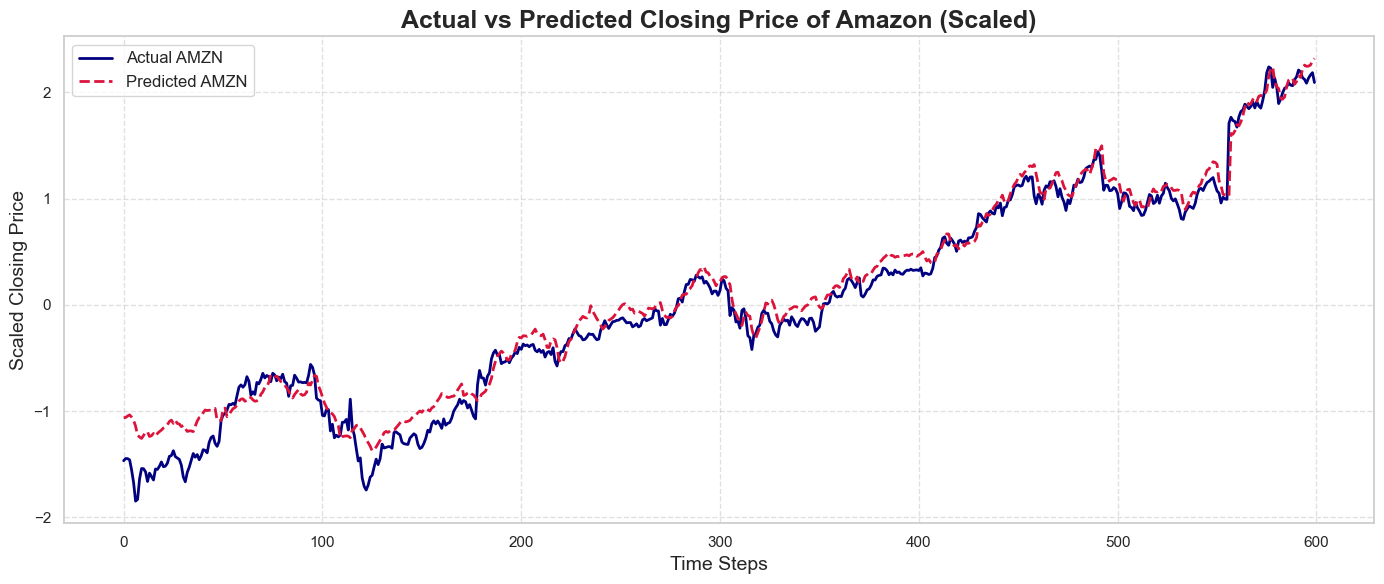

In [101]:
# Predict on the test data
# Evaluate model on test set
adv_model_test_loss, adv_model_test_mae = best_adv_model.evaluate(X_test, y_test, verbose=0)

print("\nAdvanced RNN Model - Test Set Performance")
print("--------------------------------------------------")
print(f"🔸 Mean Squared Error (MSE) : {adv_model_test_loss:.4f}")
print(f"🔸 Mean Absolute Error (MAE): {adv_model_test_mae:.4f}")
print("--------------------------------------------------")

# Predict on test set
y_pred_adv_model = best_adv_model.predict(X_test, verbose=0)

# Output shape information
print("\nOutput Shapes")
print("--------------------------------------------------")
print(f"✔️ y_test shape         : {y_test.shape}")
print(f"✔️ y_pred_adv_model shape: {y_pred_adv_model.shape}")
print("--------------------------------------------------")

mae_adv_model = mean_absolute_error(y_test, y_pred_adv_model)
mse_adv_model = mean_squared_error(y_test, y_pred_adv_model)
rmse_adv_model = np.sqrt(mse_adv_model)
r2_adv_model = r2_score(y_test, y_pred_adv_model)

print(f"\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_adv_model}")
print(f"Mean Squared Error (MSE): {mse_adv_model}")
print(f"Root Mean Squared Error (RMSE): {rmse_adv_model}")
print(f"R-squared (R²): {r2_adv_model}")

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual AMZN', color='navy', linewidth=2)
plt.plot(y_pred_adv_model, label='Predicted AMZN', color='crimson', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Closing Price of Amazon (Scaled)', fontsize=18, fontweight='bold')
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Scaled Closing Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [102]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

window_size_new = 65
window_stride_new = 5
split_ratio_new = 0.8

multi_target_cols = close_cols
print("List of target columns:", multi_target_cols)

X_train1, y_train1, X_test1, y_test1, _ = prepare_data_for_rnn(
    combined_stock_data, close_cols, window_size_new, window_stride_new, split_ratio_new
)


List of target columns: ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']


In [103]:
# Check the number of data points generated
print(f"X_train: {X_train1.shape}, y_train: {y_train1.shape}, X_test: {X_test1.shape}, y_test: {y_test1.shape}")
print(f"Training samples: {X_train1.shape[0]}")
print(f"Testing samples: {X_test1.shape[0]}")
print(f"Total data windows: {X_train1.shape[0] + X_test1.shape[0]}")



X_train: (2364, 65, 20), y_train: (2364, 4), X_test: (591, 65, 20), y_test: (591, 4)
Training samples: 2364
Testing samples: 591
Total data windows: 2955


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [104]:
# Find an optimal configuration of simple RNN

input_shape1 = X_train1.shape[1:]
target_len1 = len(multi_target_cols)
results1 = []

for units in units_list:
    for dropout in dropout_rates:
        for activation in activation_list:
            model1 = create_simple_rnn_model(units, activation, input_shape1, dropout, target_len1)
            history1 = model1.fit(X_train1, y_train1, epochs=10, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])
            val_loss1 = history1.history['val_loss'][-1]
            print(f"Simple RNN: Units={units}, Dropout={dropout}, Activation={activation}, Val_Loss={val_loss1:.4f}")
            results1.append((units, dropout, activation, val_loss1))



Simple RNN: Units=32, Dropout=0.2, Activation=tanh, Val_Loss=0.2654
Simple RNN: Units=32, Dropout=0.2, Activation=relu, Val_Loss=0.3097
Simple RNN: Units=32, Dropout=0.3, Activation=tanh, Val_Loss=0.2656
Simple RNN: Units=32, Dropout=0.3, Activation=relu, Val_Loss=0.2967
Simple RNN: Units=32, Dropout=0.5, Activation=tanh, Val_Loss=0.2198
Simple RNN: Units=32, Dropout=0.5, Activation=relu, Val_Loss=0.3875
Simple RNN: Units=64, Dropout=0.2, Activation=tanh, Val_Loss=0.1282
Simple RNN: Units=64, Dropout=0.2, Activation=relu, Val_Loss=0.1113
Simple RNN: Units=64, Dropout=0.3, Activation=tanh, Val_Loss=0.0832
Simple RNN: Units=64, Dropout=0.3, Activation=relu, Val_Loss=0.1578
Simple RNN: Units=64, Dropout=0.5, Activation=tanh, Val_Loss=0.1738
Simple RNN: Units=64, Dropout=0.5, Activation=relu, Val_Loss=0.1628
Simple RNN: Units=128, Dropout=0.2, Activation=tanh, Val_Loss=0.0625
Simple RNN: Units=128, Dropout=0.2, Activation=relu, Val_Loss=0.0945
Simple RNN: Units=128, Dropout=0.3, Activation

In [105]:
# Find the best configuration

best_config1 = sorted(results1, key=lambda x: x[3])[0]
best_units1, best_dropout1, best_activation1, _ = best_config1
print(f"Best Simple RNN Config: Units={best_units1}, Dropout={best_dropout1}, Activation={best_activation1}")


Best Simple RNN Config: Units=128, Dropout=0.3, Activation=relu


In [106]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the
best_model1 = create_simple_rnn_model(best_units1, best_activation1, input_shape1, best_dropout1, target_len1)
history1 = best_model1.fit(X_train1, y_train1, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3658 - mae: 0.4265
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0779 - mae: 0.2149
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0622 - mae: 0.1867
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0546 - mae: 0.1733
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0431 - mae: 0.1549
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0411 - mae: 0.1527
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0385 - mae: 0.1457
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0335 - mae: 0.1372
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0353 - mae: 0.1377
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0294 - mae: 0.1295
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0287 - mae: 0.1254
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0296 - mae: 0.1276
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

In [107]:
# Compute the performance of the model on the testing data set

test_loss1, test_mae1 = best_model1.evaluate(X_test1, y_test1)
print(f"Simple RNN Test Loss: {test_loss1:.4f}, MAE: {test_mae1:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0424 - mae: 0.1729 
Simple RNN Test Loss: 0.0406, MAE: 0.1685


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Performance Metrics:
Mean Absolute Error (MAE): 0.16851865763381152
Mean Squared Error (MSE): 0.04061168122092633
Root Mean Squared Error (RMSE): 0.20152340117446987
R-squared (R²): 0.9593883187790737


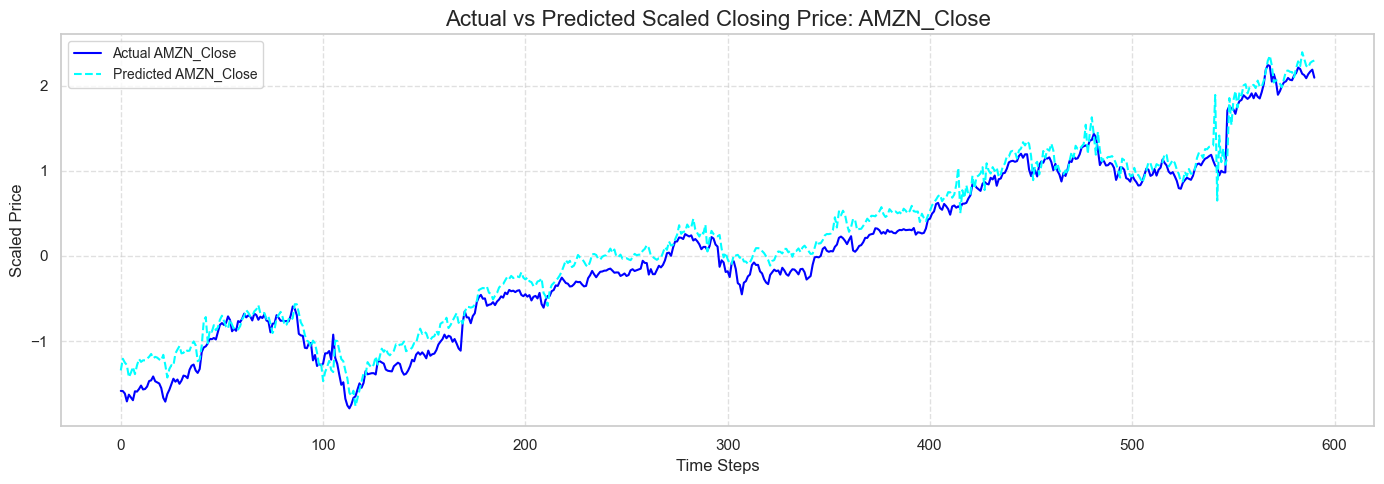

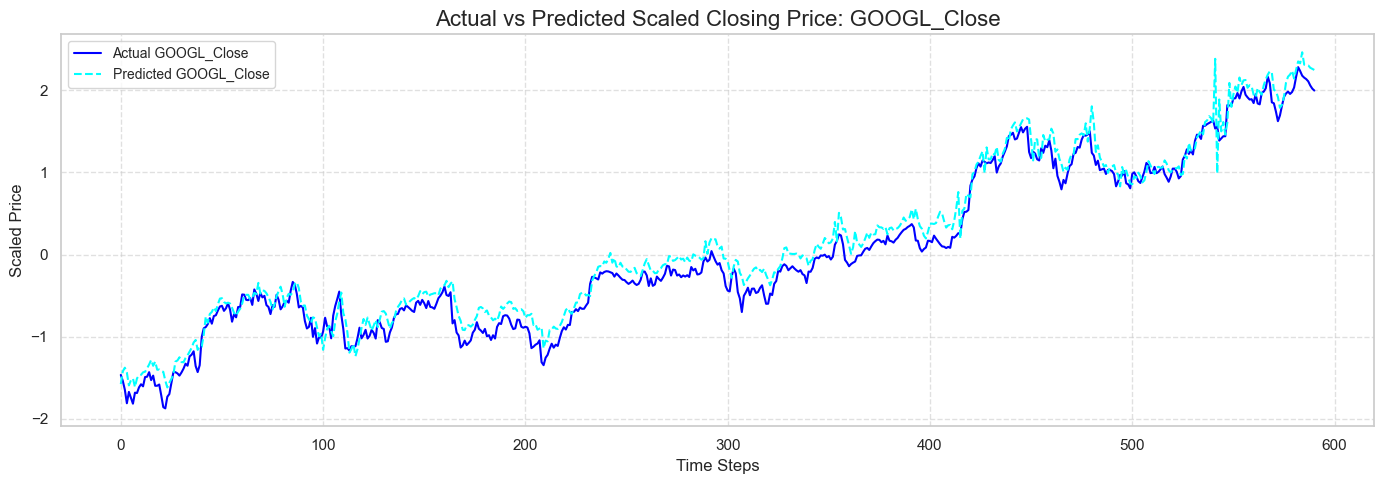

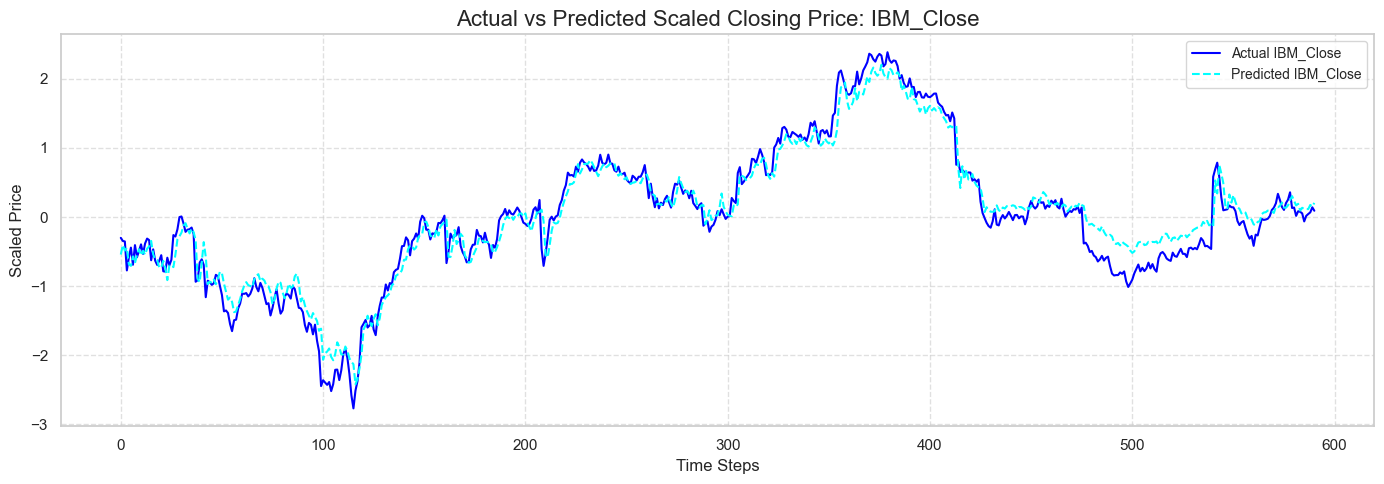

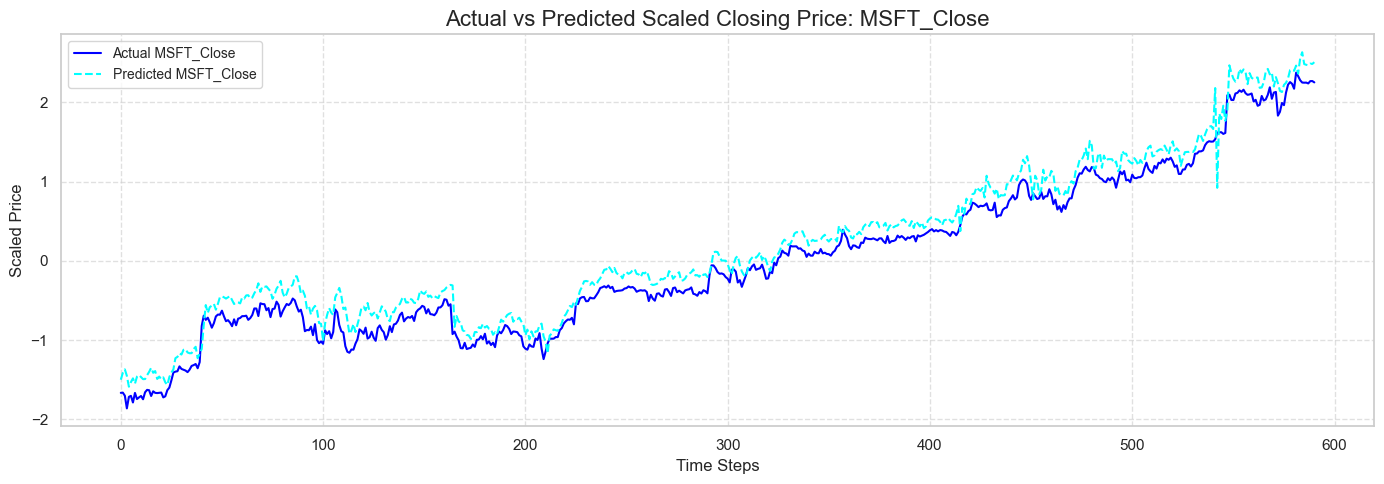

In [121]:
# Plotting the actual vs predicted values for all targets
y_pred1 = best_model1.predict(X_test1)
mae_adv_model = mean_absolute_error(y_test1, y_pred1)
mse_adv_model = mean_squared_error(y_test1, y_pred1)
rmse_adv_model = np.sqrt(mse_adv_model)
r2_adv_model = r2_score(y_test1, y_pred1)

print(f"\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_adv_model}")
print(f"Mean Squared Error (MSE): {mse_adv_model}")
print(f"Root Mean Squared Error (RMSE): {rmse_adv_model}")
print(f"R-squared (R²): {r2_adv_model}")

for i, col in enumerate(multi_target_cols):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test1[:, i], label=f'Actual {col}', color='blue')
    plt.plot(y_pred1[:, i], label=f'Predicted {col}', linestyle='--', color='cyan')
    plt.title(f'Actual vs Predicted Scaled Closing Price: {col}', fontsize=16)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Scaled Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [109]:
# Find an optimal configuration of advanced RNN
adv_results1 = []

for rnn_type in rnn_types:
    for units in units_list:
        for dropout in dropout_rates:
            for activation in activation_list:
                adv_model1 = build_advance_rnn_model(rnn_type, units, activation, input_shape1, dropout, target_len1)
                adv_model_history1 = adv_model1.fit(X_train1, y_train1, epochs=20, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])
                val_loss = adv_model_history1.history['val_loss'][-1]
                print(f"Advanced RNN: Type={rnn_type}, Units={units}, Dropout={dropout}, Activation={activation}, Val_Loss={val_loss:.4f}")
                adv_results1.append((rnn_type, units, dropout, activation, val_loss))




Advanced RNN: Type=LSTM, Units=32, Dropout=0.2, Activation=tanh, Val_Loss=0.5202
Advanced RNN: Type=LSTM, Units=32, Dropout=0.2, Activation=relu, Val_Loss=0.1104
Advanced RNN: Type=LSTM, Units=32, Dropout=0.3, Activation=tanh, Val_Loss=0.3857
Advanced RNN: Type=LSTM, Units=32, Dropout=0.3, Activation=relu, Val_Loss=1.4302
Advanced RNN: Type=LSTM, Units=32, Dropout=0.5, Activation=tanh, Val_Loss=0.5449
Advanced RNN: Type=LSTM, Units=32, Dropout=0.5, Activation=relu, Val_Loss=0.1822
Advanced RNN: Type=LSTM, Units=64, Dropout=0.2, Activation=tanh, Val_Loss=0.1546
Advanced RNN: Type=LSTM, Units=64, Dropout=0.2, Activation=relu, Val_Loss=0.3241
Advanced RNN: Type=LSTM, Units=64, Dropout=0.3, Activation=tanh, Val_Loss=0.1872
Advanced RNN: Type=LSTM, Units=64, Dropout=0.3, Activation=relu, Val_Loss=0.1058
Advanced RNN: Type=LSTM, Units=64, Dropout=0.5, Activation=tanh, Val_Loss=0.2212
Advanced RNN: Type=LSTM, Units=64, Dropout=0.5, Activation=relu, Val_Loss=0.3839
Advanced RNN: Type=LSTM, Uni

In [110]:
# Find the best configuration

adv_best_config1 = sorted(adv_results1, key=lambda x: x[4])[0]
adv_best_rnn_type1, adv_best_units1, adv_best_dropout1, adv_best_activation1, _ = adv_best_config1
print(f"Best Advanced RNN Config: Type={adv_best_rnn_type1}, Units={adv_best_units1}, Dropout={adv_best_dropout1}, Activation={adv_best_activation1}")


Best Advanced RNN Config: Type=GRU, Units=64, Dropout=0.2, Activation=tanh


In [111]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model
best_adv_model1 = build_advance_rnn_model(adv_best_rnn_type1, adv_best_units1, adv_best_activation1, input_shape1, adv_best_dropout1, target_len1)
best_adv_history1 = best_adv_model1.fit(X_train1, y_train1, epochs=20, batch_size=32, verbose=1, callbacks=[early_stopping])


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.4861 - mae: 0.4827
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0538 - mae: 0.1765
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0389 - mae: 0.1492
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0323 - mae: 0.1361
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0271 - mae: 0.1236
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0246 - mae: 0.1197
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0226 - mae: 0.1141
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0225 - mae: 0.1131
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0206 - mae: 0.1086
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0184 - mae: 0.1030
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0201 - mae: 0.1067
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0188 - mae: 0.1031
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━

In [112]:
# Compute the performance of the model on the testing data set

adv_test_loss1, adv_test_mae1 = best_adv_model1.evaluate(X_test1, y_test1)
print(f"Advanced RNN Test Loss: {adv_test_loss1:.4f}, MAE: {adv_test_mae1:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0358 - mae: 0.1583 
Advanced RNN Test Loss: 0.0376, MAE: 0.1643


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Performance Metrics:
Mean Absolute Error (MAE): 0.1643055919453265
Mean Squared Error (MSE): 0.03763862808485954
Root Mean Squared Error (RMSE): 0.19400677329634536
R-squared (R²): 0.9623613719151404


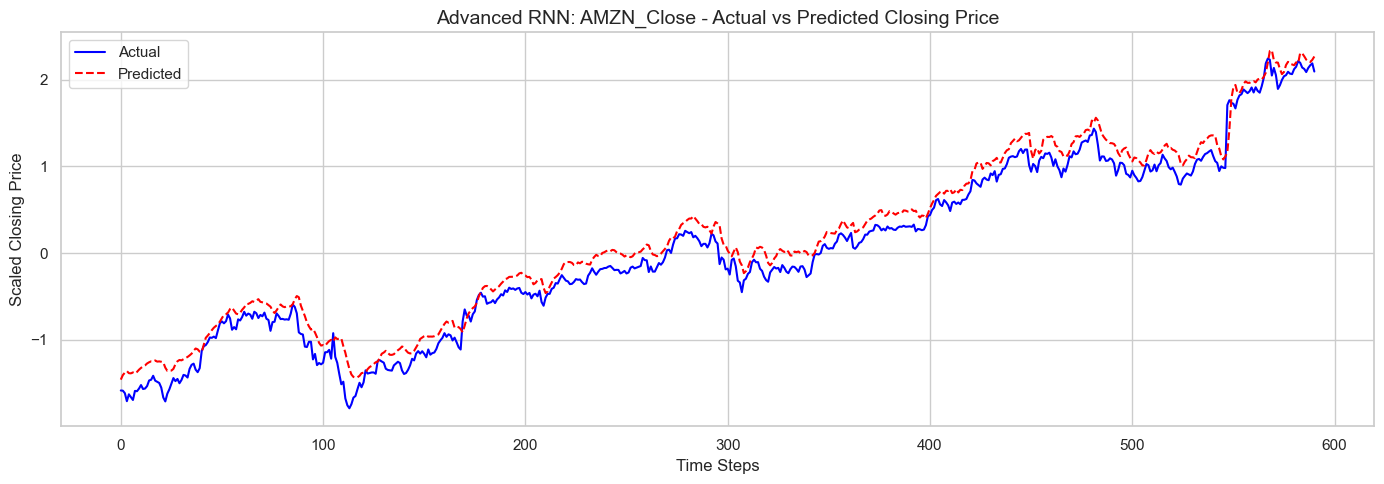

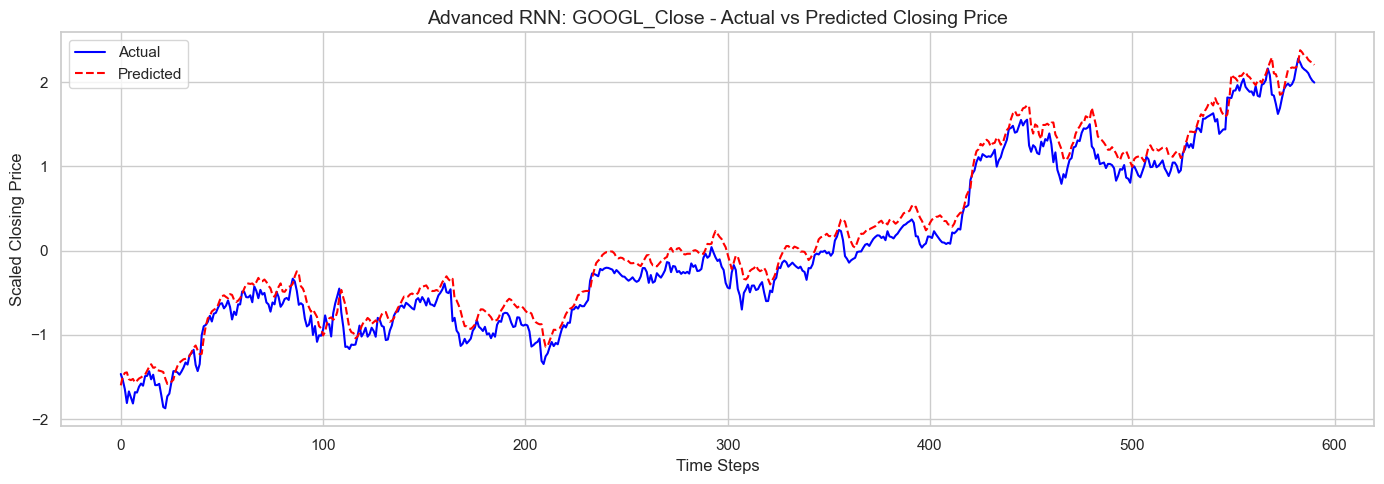

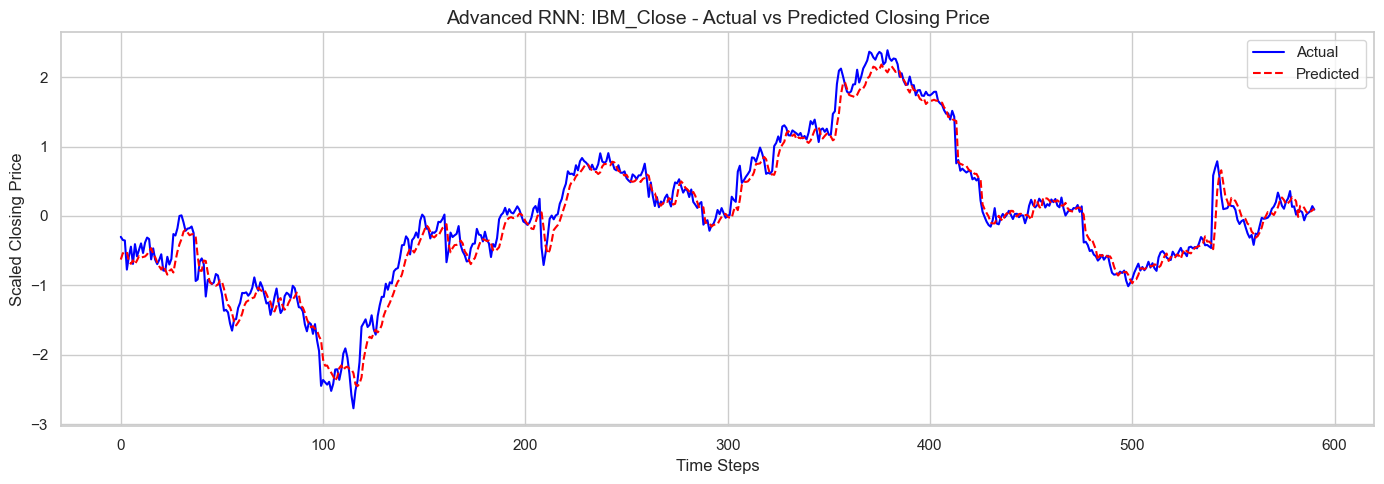

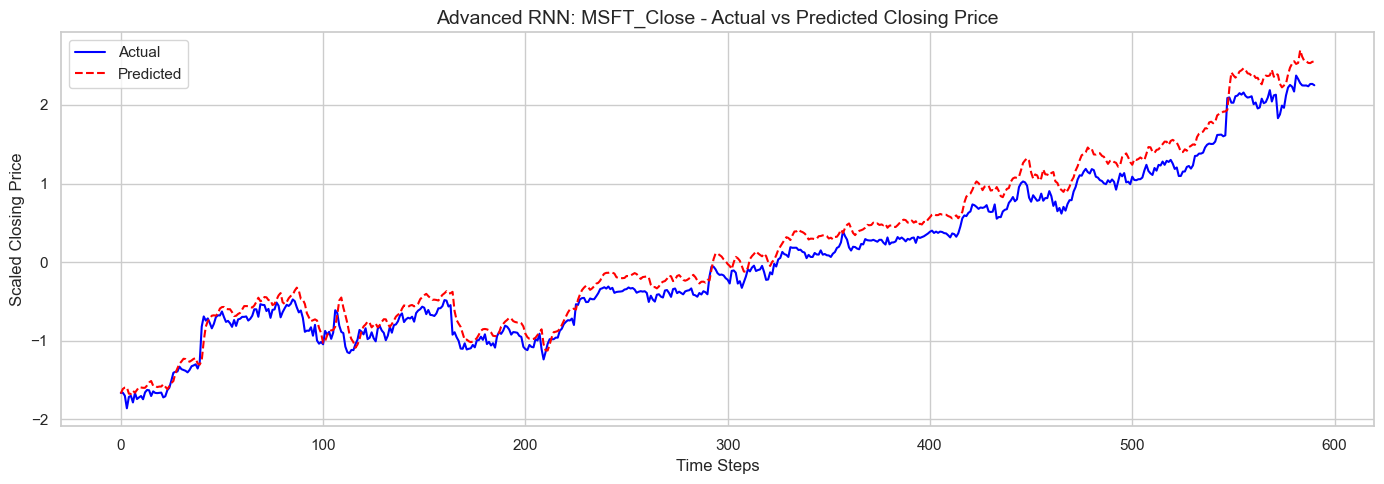

In [119]:
# Plotting the actual vs predicted values for all targets

y_pred_adv1 = best_adv_model1.predict(X_test1)

mae_adv_model = mean_absolute_error(y_test1, y_pred_adv1)
mse_adv_model = mean_squared_error(y_test1, y_pred_adv1)
rmse_adv_model = np.sqrt(mse_adv_model)
r2_adv_model = r2_score(y_test1, y_pred_adv1)

print(f"\nPerformance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_adv_model}")
print(f"Mean Squared Error (MSE): {mse_adv_model}")
print(f"Root Mean Squared Error (RMSE): {rmse_adv_model}")
print(f"R-squared (R²): {r2_adv_model}")

for i, col in enumerate(multi_target_cols):
    plt.figure(figsize=(14, 5))
    plt.plot(y_test1[:, i], label='Actual', color='blue')
    plt.plot(y_pred_adv1[:, i], label='Predicted', linestyle='--', color='red')
    plt.title(f'Advanced RNN: {col} - Actual vs Predicted Closing Price', fontsize=14)
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Closing Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

## Key Insights and Observations:

- **Single Target - AMZN Close Price**
  - *Simple RNN* performed exceptionally well with:
    - `Units = 64`, `Dropout = 0.2`, `Activation = relu`
    - Achieved a high **R² = 0.9804** on both validation and test sets
    - Very low error metrics: `MAE = 0.1037`, `RMSE = 0.1400`
    - Indicated strong model fit without overfitting

  - *Advanced RNN (GRU)*:
    - `Units = 32`, `Dropout = 0.2`, `Activation = relu`
    - Slightly higher errors (`MAE = 0.1279`, `RMSE = 0.1676`) but still strong performance
    - **R² = 0.9719** — shows good capability to learn temporal dependencies

- **Multiple Target - Multi-stock Close Prices**
  - Used `window_size = 65` and `stride = 5` for better sequence context

  - 🔹 *Simple RNN*:
    - `Units = 128`, `Dropout = 0.3`, `Activation = relu`
    - Test Loss: `0.0449`
    - Mean Absolute Error (MAE): `0.1685`
    - Mean Squared Error (MSE): `0.0406`
    - Root Mean Squared Error (RMSE): `0.2015`
    - R-squared (R²): `0.9593`
  
  - 🔹 *Advanced RNN (GRU)*:
    - `Units = 64`, `Dropout = 0.2`, `Activation = tanh`
    - Outperformed Simple RNN with lower Test Loss: `0.0376`
    - Mean Absolute Error (MAE): `0.1643`
    - Mean Squared Error (MSE): `0.0376`
    - Root Mean Squared Error (RMSE): `0.1940`
    - R-squared (R²): `0.9623`

---

## Conclusion:

- A **Simple RNN** performed exceptionally well for  **single stock prediction**, offering strong accuracy and low error rates with minimal computational complexity. It's an ideal choice when predicting just one stock's price.
- For **multi-stock predictions**, advanced RNNs like LSTM and GRU proved more effective. These models handle complex time dependencies across multiple stocks more robustly than a simple RNN.
- Among advanced models, **GRU** stood out as the best performer. It offered a great balance between prediction accuracy and training efficiency, outperforming LSTM in multi-target scenarios.
- Increasing the **window size** to **65** and using a **stride** of **5** allowed the models to learn from a broader historical context, improving their ability to capture long-term patterns in the stock data.

- Model choice should be guided by the task complexity:
    - Use simple models like RNN for quick and accurate predictions on single targets.
    - Choose advanced models (GRU or LSTM) when dealing with multiple stocks or more complex forecasting requirements.